In [48]:
import pandas as pd 
import numpy as np 

In [49]:
df_amazon_re = pd.read_csv('/Users/alros/Desktop/side01/Amazon_Reviews.csv',lineterminator='\n')

### 1.將欄位轉換成習慣的表達方式

In [50]:
df_amazon_re.rename(columns={col:col.lower().replace(" ","_") for col in df_amazon_re.columns},inplace=True)
df_amazon_re.head()

,reviewer_name,profile_link,country,review_count,review_date,rating,review_title,review_text,date_of_experience
0,Eugene ath,/users/66e8185ff1598352d6b3701a,US,1 review,2024-09-16T13:44:26.000Z,Rated 1 out of 5 stars,A Store That Doesn't Want to Sell Anything,"I registered on the website, tried to order a ...","September 16, 2024"
1,Daniel ohalloran,/users/5d75e460200c1f6a6373648c,GB,9 reviews,2024-09-16T18:26:46.000Z,Rated 1 out of 5 stars,Had multiple orders one turned up and…,Had multiple orders one turned up and driver h...,"September 16, 2024"
2,p fisher,/users/546cfcf1000064000197b88f,GB,90 reviews,2024-09-16T21:47:39.000Z,Rated 1 out of 5 stars,I informed these reprobates,I informed these reprobates that I WOULD NOT B...,"September 16, 2024"
3,Greg Dunn,/users/62c35cdbacc0ea0012ccaffa,AU,5 reviews,2024-09-17T07:15:49.000Z,Rated 1 out of 5 stars,Advertise one price then increase it on website,I have bought from Amazon before and no proble...,"September 17, 2024"
4,Sheila Hannah,/users/5ddbe429478d88251550610e,GB,8 reviews,2024-09-16T18:37:17.000Z,Rated 1 out of 5 stars,If I could give a lower rate I would,If I could give a lower rate I would! I cancel...,"September 16, 2024"


### 2.將review_count調整成僅保留評論次數

In [51]:
#評論次數為第一個字
df_amazon_re[['review_count']].head()

,review_count
0,1 review
1,9 reviews
2,90 reviews
3,5 reviews
4,8 reviews


In [52]:
#將次數獨立出來，並檢查是否有空字串
df_amazon_re['tmp'] = df_amazon_re['review_count'].apply(lambda x : x.split(" ")[0])
np.sum(df_amazon_re['tmp']=="")

0

In [53]:
#無空字串，將次數轉成int型態
df_amazon_re['review_count'] = df_amazon_re['tmp']
df_amazon_re['review_count'] = df_amazon_re['review_count'].astype('int')
df_amazon_re.drop(columns='tmp',inplace=True)
df_amazon_re['review_count'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 21055 entries, 0 to 21054
Series name: review_count
Non-Null Count  Dtype
--------------  -----
21055 non-null  int64
dtypes: int64(1)
memory usage: 164.6 KB


In [54]:
df_amazon_re[['review_count']].head()

,review_count
0,1
1,9
2,90
3,5
4,8


### 3.將rating保留分數部分

In [55]:
#評分為第二個字，滿分為第五個字
df_amazon_re[['rating']].head()

,rating
0,Rated 1 out of 5 stars
1,Rated 1 out of 5 stars
2,Rated 1 out of 5 stars
3,Rated 1 out of 5 stars
4,Rated 1 out of 5 stars


In [56]:
# 確認滿分為5分
np.sum(df_amazon_re['rating'].apply(lambda x : x.split(" ")[4])=="5")==len(df_amazon_re)

True

In [57]:
# 確認評分都在1~5之間
df_amazon_re['tmp'] = df_amazon_re['rating'].apply(lambda x : x.split(" ")[1])
np.sum(df_amazon_re['tmp'].isin([str(i) for i in range(1,6)])) == len(df_amazon_re)

True

In [58]:
#轉換成小數
df_amazon_re['rating'] = df_amazon_re['tmp'].astype(int)
df_amazon_re.drop(columns='tmp',inplace=True)
df_amazon_re['rating'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 21055 entries, 0 to 21054
Series name: rating
Non-Null Count  Dtype
--------------  -----
21055 non-null  int64
dtypes: int64(1)
memory usage: 164.6 KB


### 4.新增country_label作為country代號，以按照評論數大小的名次來標記，評論數最高標記為0，以此類推，數量相同時按照字母排

In [59]:
#從reviewer_name 可以知道這筆的country為JP
df_amazon_re.loc[df_amazon_re['country'].isna()]

,reviewer_name,profile_link,country,review_count,review_date,rating,review_title,review_text,date_of_experience
9380,JP van der Merwe,/users/60ca5fd064813d001a5d7eb9,NaN,9,2021-12-30T21:22:01.000Z,5,Pleasantly Surprised,Have purchased three separate items and had th...,"December 30, 2021"


In [60]:
#補上缺失值
df_amazon_re.loc[df_amazon_re['country'].isna(),'country'] = 'JP'

In [61]:
#先抓出次數並排序
df = df_amazon_re['country'].value_counts().to_frame('times')
df['country'] = df.index

In [62]:
#列出排名
dic = {t:d.sort_values('country',ascending=True) for t,d in df.groupby('times')}    
lst = [key for key in dic.keys()]
ary = np.sort(lst)[::-1]
df = pd.concat([dic[key] for key in ary])
df['country_label'] = [i for i in range(0,len(df))]
#進行標記
df_amazon_re['country_label'] = [df[df['country']==x]['country_label'].to_list()[0] for x in df_amazon_re['country'].to_list()]
df_amazon_re[['country_label']].head()

,country_label
0,0
1,1
2,1
3,7
4,1


### 5. review_date 調整格式：年-月-日-時分秒 和 按年、月、日、時新增四個欄位  review_date_y、review_date_m、review_date_d、review_date_t，review_date_t用24小時制表示

In [63]:
from dateutil import parser

In [64]:
#調整格式
df_amazon_re['review_date'] = df_amazon_re['review_date'].apply(lambda x: parser.parse(x).strftime("%y-%m-%d-%H%M%S"))
lst = [s.split("-") for s in df_amazon_re['review_date']]
#新增年月日時欄位
df_amazon_re['review_date_y'] = [ y[0] for y in lst]
df_amazon_re['review_date_m'] = [ m[1] for m in lst]
df_amazon_re['review_date_d'] = [ d[2] for d in lst]
df_amazon_re['review_date_t'] = [ t[3] for t in lst]
df_amazon_re  = df_amazon_re[['reviewer_name', 'profile_link', 'country', 'country_label',
       'review_count', 'review_date','review_date_y', 'review_date_m', 'review_date_d',
       'review_date_t', 'rating', 'review_title', 'review_text',
       'date_of_experience']]

In [65]:
df_amazon_re['review_date'].apply(lambda x: x.split('.')[0])

0        24-09-16-134426
1        24-09-16-182646
2        24-09-16-214739
3        24-09-17-071549
4        24-09-16-183717
              ...       
21050    09-03-22-131412
21051    08-12-31-185731
21052    08-09-16-130505
21053    08-04-28-110905
21054    07-08-27-172501
Name: review_date, Length: 21055, dtype: object

### 6. date_of_experience 調整格式：年-月-日 和 按年、月、日新增三個欄位  date_of_experience_y、date_of_experience_m、date_of_experience_d

In [66]:
#調整格式
df_amazon_re["date_of_experience"] =  df_amazon_re["date_of_experience"].apply(lambda x:parser.parse(x).strftime("%y-%m-%d"))
lst = [s.split("-") for s in df_amazon_re['date_of_experience']]
#新增年月日時欄位
df_amazon_re['date_of_experience_y'] = [ y[0] for y in lst]
df_amazon_re['date_of_experience_m'] = [ m[1] for m in lst]
df_amazon_re['date_of_experience_d'] = [ d[2] for d in lst]
df_amazon_re = df_amazon_re[['reviewer_name', 'profile_link', 'country', 'country_label',
       'review_count', 'review_date', 'review_date_y', 'review_date_m',
       'review_date_d', 'review_date_t', 'rating', 'review_title',
       'review_text', 'date_of_experience', 'date_of_experience_y',
       'date_of_experience_m', 'date_of_experience_d']]

### 7. review_title 和 review_text 結合 分成10群，並根據群組歸類出其評論種類

In [67]:
from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

In [68]:
n_clusters = 10

In [69]:
#合併兩個內容
lst_title = df_amazon_re['review_title'].to_list()
lst_text = df_amazon_re['review_text'].to_list()
lst = []
for i in range(0,len(lst_text)): 
    lst.append("title:" + lst_title[i] + "\ntext:" + lst_text[i])
df_amazon_re['review_title_text'] = lst

In [70]:
#向量編碼
model = SentenceTransformer("paraphrase-distilroberta-base-v1")
ary_review_title_text = model.encode(lst)
ary_review_title_text.shape

/Users/alros/miniforge3/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(21055, 768)

<AxesSubplot: xlabel='1', ylabel='0'>

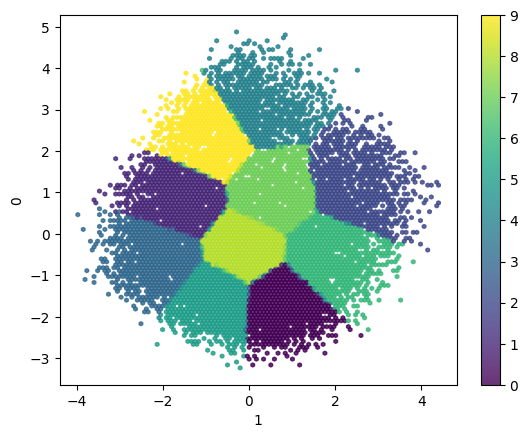

In [71]:
#這邊先用PCA將成2維觀察分群結果
pca = PCA(n_components=2)
ary = pca.fit_transform(ary_review_title_text)
kmeans = KMeans(n_clusters=n_clusters, random_state=20).fit(ary)
labels = kmeans.predict(ary)
df = pd.DataFrame(ary)
df['lbl'] = labels
df.plot.hexbin(x=1,y=0,C='lbl',cmap="viridis",alpha=0.8)

In [72]:
#進行分群
df_amazon_re['review_title_text_category'] = KMeans(n_clusters=n_clusters, random_state=20).fit_predict(ary_review_title_text)

In [73]:
import re
import nltk
from nltk.stem import WordNetLemmatizer 
from collections import Counter

nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words('english')
lst_stopwords.append('amazon')

[nltk_data] Downloading package stopwords to /Users/alros/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [74]:
def convert(sentences):
    lemmatizer = WordNetLemmatizer()

    lst_sentences = []
    for s in sentences:
        s = s.replace('title','')
        s = s.replace('text','')
        lst = []
        for ss in s.split(" "):
            word = re.search('\w+', ss)
            if word is not None:
                word = word.group()
                word = word.lower()
                word = lemmatizer.lemmatize(word)
                if word not in lst_stopwords:
                    lst.append(word)
        lst_sentences.append(" ".join(lst))
    return " ".join(lst_sentences).split(" ")

In [75]:
#透過每的主題的前50出現頻率最高的字，確認評論的種類
lst = []
for i in range(10):
    s = convert(df_amazon_re.loc[df_amazon_re['review_title_text_category']==i,['review_title_text']]['review_title_text'].to_list())
    word_counts = Counter(s)
    print(f"第{i}類:" + ",".join([ word for word, count  in word_counts.most_common(50)]))

第0類:delivery,wa,day,item,order,service,time,delivered,customer,get,prime,package,driver,would,ordered,2,parcel,next,ha,said,one,never,even,told,refund,week,say,door,deliver,back,still,today,got,3,shipping,date,could,company,left,late,wait,two,product,received,another,call,email,hour,address,arrive
第1類:customer,service,delivery,wa,item,time,order,day,prime,get,ha,package,one,company,issue,never,product,year,even,delivered,problem,always,good,shipping,would,return,refund,used,like,thing,driver,back,2,go,money,review,great,ordered,say,many,experience,use,week,really,take,need,make,deliver,call,wrong
第2類:great,love,service,prime,always,good,price,product,shopping,best,item,time,customer,online,delivery,buy,get,shipping,order,everything,ha,find,day,wa,thing,site,use,book,shop,company,one,need,fast,like,experience,year,never,easy,free,many,purchase,want,go,really,place,anything,website,also,excellent,would
第3類:service,customer,wa,time,company,get,item,order,delivery,worst,refund,even,account

### 將關鍵字丟給ChatGPT作推論：
0: 遞送與物流體驗 - 主要涉及消費者對配送效率、包裹狀態和配送服務的評價</br>
1: 客戶服務與問題回應 - 聚焦於消費者對客戶服務的評價，特別是對問題解決和退款處理的滿意度</br>
2: 正面購物體驗 - 展現消費者對產品品質、價格和整體購物體驗的高度滿意度</br>
3: 負面服務經歷 - 反映消費者對不良服務體驗的批評，包含客服無回應、退款和產品問題</br>
4: 帳戶與支付問題 - 涉及消費者對帳戶管理、信用卡扣款及支付退款相關的問題與擔憂</br>
5: 產品及服務的不滿意 - 反映消費者對產品質量或服務回應不滿的情緒</br>
6: 優質服務評價 - 描述消費者對優質、快速且可靠服務的正面回饋</br>
7: 商家評價與信任 - 涉及消費者對商家信任度和整體購物體驗的評價，特別是產品與商家聲譽的考量</br>
8: 退貨與退款過程 - 針對退貨及退款流程的評價，關注是否順利完成和處理速度</br>
9: 平台使用體驗 - 反映消費者對購物平台或網站使用體驗的評價，包括操作便捷性和整體滿意度</br>

In [76]:
df_amazon_re = df_amazon_re[['reviewer_name', 'profile_link', 'country', 'country_label',
       'review_count', 'review_date', 'review_date_y', 'review_date_m','review_date_d', 'review_date_t',
       'rating', 'review_title','review_text','review_title_text', 'review_title_text_category',
       'date_of_experience', 'date_of_experience_y','date_of_experience_m', 'date_of_experience_d']]

In [77]:
df = df_amazon_re[['reviewer_name', 'profile_link', 'country', 'country_label',
       'review_count','review_date_y', 'review_date_m','review_date_d', 'review_date_t',
       'rating', 'review_title_text', 'review_title_text_category',
        'date_of_experience_y','date_of_experience_m', 'date_of_experience_d']]

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21055 entries, 0 to 21054
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   reviewer_name               21055 non-null  object
 1   profile_link                21055 non-null  object
 2   country                     21055 non-null  object
 3   country_label               21055 non-null  int64 
 4   review_count                21055 non-null  int64 
 5   review_date_y               21055 non-null  object
 6   review_date_m               21055 non-null  object
 7   review_date_d               21055 non-null  object
 8   review_date_t               21055 non-null  object
 9   rating                      21055 non-null  int64 
 10  review_title_text           21055 non-null  object
 11  review_title_text_category  21055 non-null  int32 
 12  date_of_experience_y        21055 non-null  object
 13  date_of_experience_m        21055 non-null  ob

In [79]:
dic={'reviewer_name': str,
        'profile_link': str,
        'country': str,
        'country_label': int,
        'review_count': int,
        'review_date_y': int,
        'review_date_m': int,
        'review_date_d': int,
        'review_date_t': int,
        'rating': int,
        'review_title_text': str,
        'review_title_text_category': int,
        'date_of_experience_y': int,
        'date_of_experience_m': int,
        'date_of_experience_d': int}

In [80]:
df = df.astype(dic)

In [81]:
df.to_excel('amzon_review_ok.xlsx')